The purpose of this notebook is to look at how the different xylem damage models impact the optimal stomatal size and resulting CO2 flux of a tree over time.

In [1]:
import sys
sys.path.append('../')

from src.vapour_pressure_deficit_calculation import vapour_pressure_deficit
from src.leaf_air_coupling_model import LeafAirCouplingModel
from src.rubisco_CO2_and_O_model import RubiscoRates
from src.electron_transport_rate_model import ElectronTransportRateModel

# -- Conductance models --
from src.HydraulicConductanceModels.cumulative_Weibull_distribution_model import cumulative_Weibull_distribution_from_conductance_loss_at_given_water_potentials
from src.HydraulicConductanceModels.capped_conductance_model import CappedHydraulicConductanceModel
from src.HydraulicConductanceModels.D_S_Mackay_damage_model import D_S_Mackay_damage_model_from_conductance_loss

# -- Temperature dependency models --
from src.TemperatureDependenceModels.arrhenius_and_peaked_arrhenius_function import PeakedArrheniusModel, ArrheniusModel
from src.TemperatureDependenceModels.Q10_temperature_dependence_model import Q10TemperatureDependenceModel
from src.TemperatureDependenceModels.temperature_dependence_model import LowTemperatureAdjustedModel

# -- Photosynthesis models --
from src.PhotosynthesisModels.photosynthesis_model import PhotosynthesisModel
from src.PhotosynthesisModels.Bonan_Model import PhotosynthesisModelRubiscoLimitedBonan as PhotosynthesisModelRubiscoLimited
from src.PhotosynthesisModels.Bonan_Model import PhotosynthesisModelElectronTransportLimitedBonan as PhotosynthesisModelElectronTransportLimited

# -- Profit Models --
from src.ProfitModels.CO2GainModels.CO2_gain_profit_max_model import ProfitMaxCO2GainModel as CO2GainModel
from src.ProfitModels.HydraulicCostModels.hydraulic_cost_profit_max_model import ProfitMaxHydraulicCostModel as HydraulicCostModel
from src.ProfitModels.profit_max_model import ProfitMaxModel

from src.conversions import (magnitude_conversion,
                             mole_carbon_to_grams,
                             per_day_to_per_second,
                             per_second_to_per_half_hour,
                             convert_transpiration_rate_to_latent_energy,
                             short_wave_to_photosynthetically_active_radiation,
                             light_energy_in_joules_to_micro_moles_of_light,
                             degrees_kelvin_to_centigrade,
                             degrees_centigrade_to_kelvin,
                             convert_stomatal_conductance_of_carbon_to_water)

from xarray import open_dataset
from pandas import DataFrame, date_range
from numpy import nan, zeros

from matplotlib import pyplot as plt

# Model setup

Before we are able to investigate. anything it is necessary to setup a control and multiple test models. For comparative purposes we will use a cumulative Weibull distribution as the base conductance model, with the xylem damage models being both a capped conductance model, and the model described in [D.S.Mackay et. al. 2015](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2015WR017244).

## Conductance Model
The code segment bellow sets up the three different conductance models with xylem damage.

In [2]:
# Conductance model
P50 = -4.739999999999999 # MPa
P88 = -5.476604474129552 # MPa
k_max = 0.2 # mmol m-2 s-1 MPa-1

critical_conductance_loss_fraction = 0.9
xylem_recovery_water_potnetial = 0.
PLC_damage_threshold = 0.1

default_CW_conductance_model = cumulative_Weibull_distribution_from_conductance_loss_at_given_water_potentials(k_max,
                                                                                                               P50,
                                                                                                               P88,
                                                                                                               0.50,
                                                                                                               0.88,
                                                                                                               critical_conductance_loss_fraction,
                                                                                                               xylem_recovery_water_potnetial,
                                                                                                               PLC_damage_threshold
                                                                                                              )

capped_CW_conductance_model = CappedHydraulicConductanceModel(default_CW_conductance_model,
                                                              1.1*k_max
                                                             )

D_S_Mackay_CW_conductance_model = D_S_Mackay_damage_model_from_conductance_loss(k_max,
                                                                                P50,
                                                                                P88,
                                                                                0.50,
                                                                                0.88,
                                                                                critical_conductance_loss_fraction,
                                                                                xylem_recovery_water_potnetial,
                                                                                PLC_damage_threshold
                                                                               )

## Hydraulic cost models

In [3]:
critical_leaf_water_potential = default_CW_conductance_model.water_potential_from_conductivity_loss_fraction(0.95)

default_CW_hydraulic_cost_model = HydraulicCostModel(default_CW_conductance_model,
                                                     critical_leaf_water_potential
                                                    )

capped_CW_hydraulic_cost_model = HydraulicCostModel(capped_CW_conductance_model,
                                                    critical_leaf_water_potential
                                                   )

D_S_Mackay_CW_hydraulic_cost_model = HydraulicCostModel(D_S_Mackay_CW_conductance_model,
                                                        critical_leaf_water_potential
                                                       )

## Leaf atmosphere coupling

In [4]:
leaf_air_coupling_model = LeafAirCouplingModel()

## Photosynthesis model

In [5]:
# -- Rubisco limited model --
photosynthesis_rubisco_limited_model = PhotosynthesisModelRubiscoLimited()

# -- Electron transport rate limmited model --
photosynthesis_electron_transport_limited_model = PhotosynthesisModelElectronTransportLimited()

photosynthesis_model = PhotosynthesisModel(photosynthesis_rubisco_limited_model,
                                           photosynthesis_electron_transport_limited_model
                                          )

## CO2 gain

In [6]:
CO2_gain_model = CO2GainModel(leaf_air_coupling_model,
                              photosynthesis_model)

## Profet optimisation models

Now we create a profit optimisation model for each of the different conductance models.

In [7]:
default_CW_profit_optimisation_model = ProfitMaxModel(default_CW_hydraulic_cost_model,
                                                      leaf_air_coupling_model,
                                                      CO2_gain_model
                                                     )

capped_CW_profit_optimisation_model = ProfitMaxModel(capped_CW_hydraulic_cost_model,
                                                     leaf_air_coupling_model,
                                                     CO2_gain_model
                                                    )

D_S_Mackay_CW_profit_optimisation_model = ProfitMaxModel(D_S_Mackay_CW_hydraulic_cost_model,
                                                         leaf_air_coupling_model,
                                                         CO2_gain_model
                                                        )

# constant environmental conditions

The first thing to test is how the different models behave under the set of constant environmental conditions listed in the code block below.

In [8]:
# Soil properties
soil_water_potential = -0.5 # MPa

# Temperature
air_temperature = degrees_centigrade_to_kelvin(25.)

# Transpiration drivers
air_vapour_pressure_deficit = 1 # kPa
air_pressure = 101.9 # kPa

# Photosynthesis drivers
atmospheric_CO2_concentration = 419. # (umol mol-1)
photosynthetically_active_radiation = 500. #(umol m-2 s-1)
intercellular_oxygen = 210.0 #(umol mol-1)

Lets apply this over a series of time steps recording the outputs of each model.

In [11]:
time_steps = 100
time_step_size = 0.5 # h

time = [i*time_step_size for i in range(time_steps)]

# Number of sample points used when finding optimal leaf water potential
number_of_sample_points = 1000

# -- setup output arrays --
optimal_leaf_water_potential = zeros([time_steps, 3])
net_CO2_uptake               = zeros([time_steps, 3])
transpiration_rate           = zeros([time_steps, 3])
intercellular_CO2            = zeros([time_steps, 3])
stomatal_conductance_to_CO2  = zeros([time_steps, 3])

for i in range(time_steps):
    [optimal_leaf_water_potential[i,0],
     net_CO2_uptake[i,0],
     transpiration_rate[i,0],
     intercellular_CO2[i,0],
     stomatal_conductance_to_CO2[i,0]] = default_CW_profit_optimisation_model.calculate_time_step(time_step_size,
                                                                                                  soil_water_potential,
                                                                                                  air_temperature,
                                                                                                  air_vapour_pressure_deficit,
                                                                                                  air_pressure,
                                                                                                  atmospheric_CO2_concentration,
                                                                                                  intercellular_oxygen,
                                                                                                  photosynthetically_active_radiation,
                                                                                                  number_of_sample_points)

    [optimal_leaf_water_potential[i,1],
     net_CO2_uptake[i,1],
     transpiration_rate[i,1],
     intercellular_CO2[i,1],
     stomatal_conductance_to_CO2[i,1]] = capped_CW_profit_optimisation_model.calculate_time_step(time_step_size,
                                                                                                 soil_water_potential,
                                                                                                 air_temperature,
                                                                                                 air_vapour_pressure_deficit,
                                                                                                 air_pressure,
                                                                                                 atmospheric_CO2_concentration,
                                                                                                 intercellular_oxygen,
                                                                                                 photosynthetically_active_radiation,
                                                                                                 number_of_sample_points)

    [optimal_leaf_water_potential[i,2],
     net_CO2_uptake[i,2],
     transpiration_rate[i,2],
     intercellular_CO2[i,2],
     stomatal_conductance_to_CO2[i,2]] = D_S_Mackay_CW_profit_optimisation_model.calculate_time_step(time_step_size,
                                                                                                     soil_water_potential,
                                                                                                     air_temperature,
                                                                                                     air_vapour_pressure_deficit,
                                                                                                     air_pressure,
                                                                                                     atmospheric_CO2_concentration,
                                                                                                     intercellular_oxygen,
                                                                                                     photosynthetically_active_radiation,
                                                                                                     number_of_sample_points)

Exception: water_potential_from_conductivity_loss_fraction not calculable in capped conductance model

Having done the calculation lets plot the CO2 uptake as a function of time.

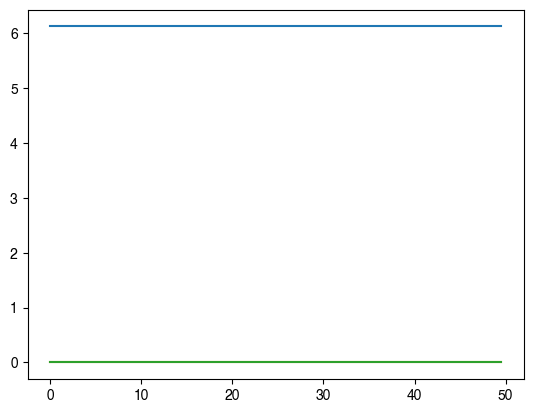

In [10]:
for i in range(3):
    plt.plot(time, net_CO2_uptake[:,i])

plt.show()